<a href="https://colab.research.google.com/github/woongjoonchoi/DeepLearningPaper-Reproducing/blob/master/Vgg/vgg_train_image_singe_and_multi_scale_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import albumentations as A
import numpy as np

import matplotlib.pyplot as plt
from torchvision.datasets import Caltech256 ,Caltech101 ,CIFAR100
import os
from PIL import Image
from urllib.request import urlretrieve
import requests
import tarfile

## Define rescaling , flip,rbgshift,crop  for singe scale

In [ ]:
trans_small_single_256 = A.Compose(
    [
        A.SmallestMaxSize(max_size=256),
        A.RandomCrop(height =256,width=256),
        A.HorizontalFlip(),
        A.RGBShift()
    ]

)

In [ ]:
trans_large_single_256 = A.Compose(
    [
        A.RandomCrop(height =256,width=256),
        A.HorizontalFlip(),
        A.RGBShift()
    ]

)

In [ ]:
trans_single=A.Compose(
    [
        A.SmallestMaxSize(max_size=256),
        A.RandomCrop(height =256,width=256),
        A.HorizontalFlip(),
        A.RGBShift()
    ]

)

In [ ]:
trans_all=[trans_small_single_256,trans_large_single_256]

## Random image upload to your directory


In [ ]:

pillow_image= Image.open(os.path.joini(os.getcwd(),"image.jpg"))

image = np.array(pillow_image)

In [ ]:
original_image = image

In [ ]:
transformed= trans1(image=image)

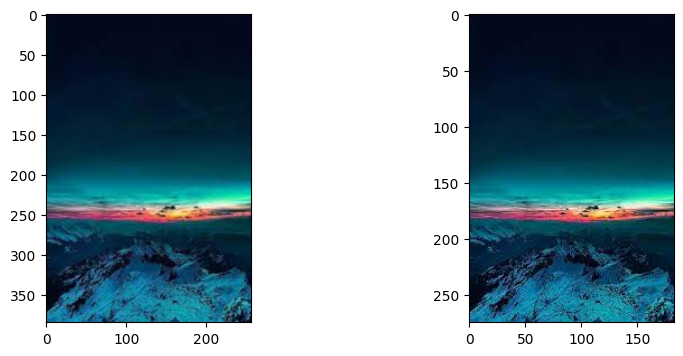

In [ ]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)

plt.imshow(transformed['image'])

plt.subplot(1,2,2)
plt.imshow(original_image)

## File Download Manually From caltech


In [ ]:
os.makedirs(os.path.join(os.getcwd(),'caltech256'))
file_url = "https://data.caltech.edu/records/nyy15-4j048/files/256_ObjectCategories.tar?download=1"

r = requests.get(file_url, stream = True)
with open(os.path.join(os.getcwd(),'caltech256','256_ObjectCategories.tar'),"w+b") as f:
    for chunk in r.iter_content(chunk_size=1024):
        if chunk:
            f.write(chunk)
with tarfile.open(os.path.join(os.getcwd(),'caltech256','256_ObjectCategories.tar') ,'r') as f:
    f.extractall(os.path.join(os.getcwd(),'caltech256'))

## Define Single,Multiscale crop

# 새 섹션

In [ ]:
class Custom_Caltech(Caltech256) :
    def __init__(self,root,transform=None,multi=False):

        super().__init__(root,transform=transform)
        self.multi = multi
        self.s_max = 512
        self.s_min= 256
    def __getitem__(self, index: int) :
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img = Image.open(
            os.path.join(
                self.root,
                "256_ObjectCategories",
                self.categories[self.y[index]],
                f"{self.y[index] + 1:03d}_{self.index[index]:04d}.jpg",
            )
        )
        img=np.array(img)
        # print(img.shape)
        target = self.y[index]
        if self.transform is not None:
            S=None
            if self.multi :
                print('multi scale')
                S = np.random.randint(low=self.s_min,high=self.s_max)
                img = A.SmallestMaxSize(max_size=S)(image=img)['image']
            elif min(img.shape[0],img.shape[1]) <256 :
                print('less than 256')
                img = A.SmallestMaxSize(max_size=256)(image=img)['image']
            else :
                print('bigger than 256')
            img = self.transform(image=img)


        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

In [ ]:
class Custom_Cifar(CIFAR100) :
    def __init__(self,root,transform = None,multi=False,download=False):

        super().__init__(root,transform=transform,download=download)
        self.multi = multi
        self.s_max = 512
        self.s_min= 256
    def __getitem__(self, index: int) :
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.targets[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        # img = Image.fromarray(img)

        if self.transform is not None:
            S=None
            if self.multi :
                print('multi scale')
                S = np.random.randint(low=self.s_min,high=self.s_max)
                img = A.SmallestMaxSize(max_size=S)(image = img)['image']
                # print(img.keys())
            elif min(img.shape[0],img.shape[1]) <self.s_min :
                print(f'less than {self.s_min}')
                img = A.SmallestMaxSize(max_size=self.s_min)(image = img)['image']
            else :
                print(f'bigger than {self.s_min}')
            img = self.transform(image=img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

### Define CustomClass single scale crop

In [ ]:
real_cifar = CIFAR100(root=os.getcwd(),download=True)

Files already downloaded and verified


In [ ]:
custom_cifar= Custom_Cifar(root=os.getcwd(),transform = trans_single,download=True)

Files already downloaded and verified


In [ ]:
real_caltech = Caltech256(root=os.getcwd())

In [ ]:
test_caltech = Custom_Caltech(root=os.getcwd(),transform=trans_single)

less than 256


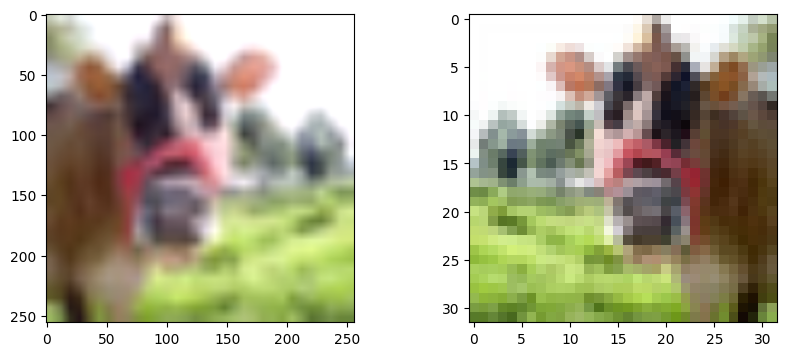

In [ ]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)

plt.imshow(custom_cifar[0][0]['image'])

plt.subplot(1,2,2)
plt.imshow(np.array(real_cifar[0][0]))


bigger than 256


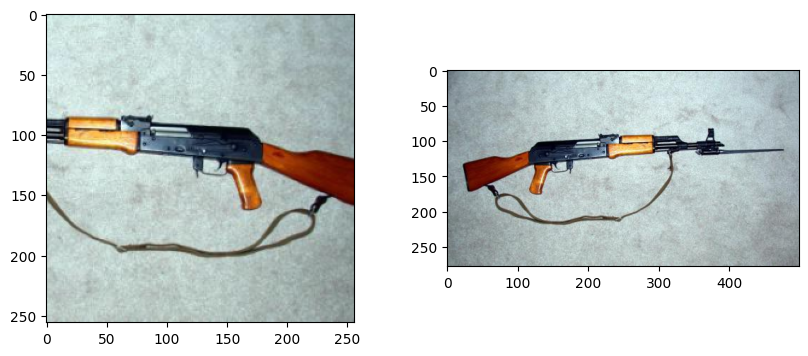

In [ ]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)

plt.imshow(test_caltech[0][0]['image'])

plt.subplot(1,2,2)
plt.imshow(np.array(real_caltech[0][0]))


### Define MultiScale Crop


In [ ]:
real_cifar = CIFAR100(root=os.getcwd(),download=True,multi = True)

Files already downloaded and verified


In [ ]:
multi_custom_cifar= Custom_Cifar(root=os.getcwd(),transform = trans_single,download=True , multi=True)

Files already downloaded and verified


In [ ]:
real_caltech = Caltech256(root=os.getcwd())

In [ ]:
multi_test_caltech = Custom_Caltech(root=os.getcwd(),transform=trans_single,multi=True)

multi scale


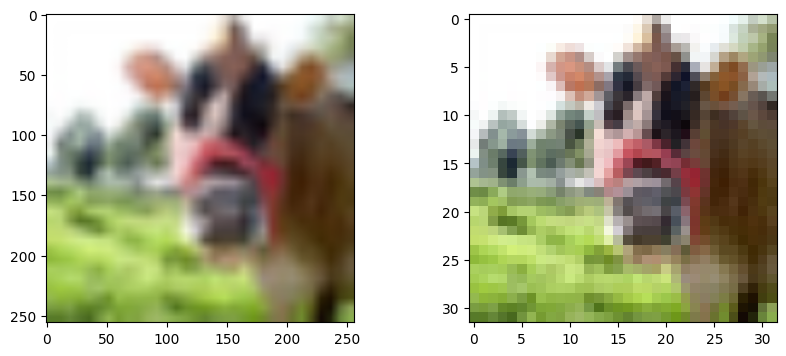

In [ ]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)

plt.imshow(multi_custom_cifar[0][0]['image'])

plt.subplot(1,2,2)
plt.imshow(np.array(real_cifar[0][0]))


multi scale


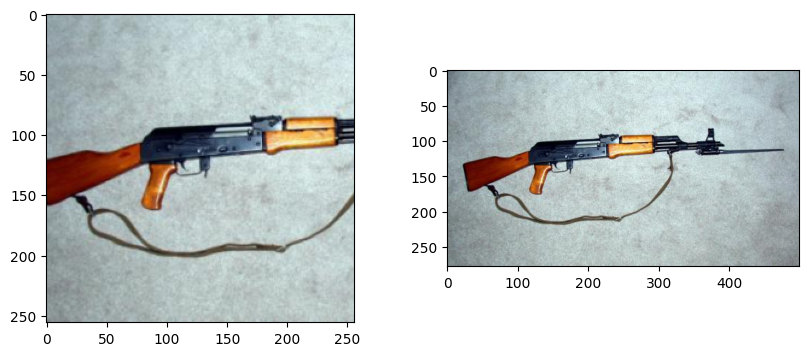

In [ ]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)

plt.imshow(multi_test_caltech[0][0]['image'])

plt.subplot(1,2,2)
plt.imshow(np.array(real_caltech[0][0]))
